<a href="https://colab.research.google.com/github/janosepah/ML_Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Electricity Supply and Demand
Team Members (alphabetical order):
-	Samarah Azimpoor
-	Safoura Janosepah


# Power Data Source - IESO

## Market Demand
### Market Demand Definitions and Graphs
The graph below plots values for both Total Market Demand and Ontario Demand.

- **Total Market Demand** represents the total energy that was supplied from the IESO-Administered Market.

The IESO calculates Total Market Demand by summing all output from generators registered in the Market plus all scheduled imports to the province. It is also equal to the sum of all load supplied from the Market plus exports from the province, plus all line losses incurred on the IESO-controlled grid.

- **Ontario Demand** represents the total energy that was supplied from the IESO-Administered Market for the purpose of supplying load within Ontario.

It is also equal to the sum of all loads within Ontario which is supplied from the Market, plus all line losses incurred on the IESO-controlled grid.


##**Table of Content**

1.   Importing Liblaries
2.   Loading the Data
3.   Data Pre-Processing
4.   Feature Engineering
5.   Data Visualisation
6.   Designing Models
 
 6.1.   XGBoost
       * Train & Test Split
       * Creating XGBoost model
       * Prediction
       * EvaluationList item
 
 6.2.  RNN
       * Train & Test Split
       * Creating RNN model
       * Prediction
       * EvaluationList item
 
 6.3.   LSTM
       * Train & Test Split
       * Creating LSTM model
       * Prediction
       * EvaluationList item

7.    Evaluating Final Models



##1. **Importing Liblaries**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import calendar


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set default plot styles
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

##2. **Loading The Data**

In [7]:
# Load Data 
Data_Path = 'https://raw.githubusercontent.com/janosepah/ML_Project/master/Data/'

# Demand
Demand_2015 = pd.read_csv(Data_Path + 'PUB_Demand_2015.csv', parse_dates=['Date'])
Demand_2015.head()

Demand_2016 = pd.read_csv(Data_Path + 'PUB_Demand_2016.csv', parse_dates=['Date'])
Demand_2016.head()

Demand_2017 = pd.read_csv(Data_Path + 'PUB_Demand_2017.csv', parse_dates=['Date'])
Demand_2017.head()
#Demand_2017.shape

Demand_2018 = pd.read_csv(Data_Path + 'PUB_Demand_2018.csv', parse_dates=['Date'])
Demand_2018.head()
#Demand_2018.shape

Demand_2019 = pd.read_csv(Data_Path + 'PUB_Demand_2019.csv', parse_dates=['Date'])
Demand_2019.head()
#Demand_2019.shape

# Supply
Supply_2015 = pd.read_csv(Data_Path + '2015_Hourly_Output.csv', parse_dates=['Date'])
Supply_2015.head()

Supply_2016 = pd.read_csv(Data_Path + '2016_Hourly_Output.csv', parse_dates=['Date'])
Supply_2016.head()

Supply_2017 = pd.read_csv(Data_Path + '2017_Hourly_Output.csv', parse_dates=['Date'])
Supply_2017.head()
#Supply_2017.shape

Supply_2018 = pd.read_csv(Data_Path + '2018_Hourly_Output.csv', parse_dates=['Date'])
Supply_2018.head()
#Supply_2018.shape

Supply_2019 = pd.read_csv(Data_Path + '2019_Hourly_Output.csv', parse_dates=['Date'])
Supply_2019.head()
#Supply_2019.shape

# Industry
Industrial_2019 =pd.read_csv(Data_Path + 'Industrial_Load_2019.csv', parse_dates=['DeliveryDate'])
Industrial_2019.head()

Industrial_2018 =pd.read_csv(Data_Path + 'Industrial_Load_2018.csv', parse_dates=['DeliveryDate'])
Industrial_2018.head()

Industrial_2017 =pd.read_csv(Data_Path + 'Industrial_Load_2017.csv', parse_dates=['DeliveryDate'])
Industrial_2017.head()

Industrial_2016 =pd.read_csv(Data_Path + 'Industrial_Load_2016.csv', parse_dates=['DeliveryDate'])
Industrial_2016.head()

Industrial_2015 =pd.read_csv(Data_Path + 'Industrial_Load_2015.csv', parse_dates=['DeliveryDate'])
Industrial_2015.head()

# DemandZonal
DemandZonal_2015 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2015.csv', parse_dates=['Date'])
DemandZonal_2015.head()

DemandZonal_2016 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2016.csv', parse_dates=['Date'])
DemandZonal_2016.head()

DemandZonal_2017 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2017.csv', parse_dates=['Date'])
DemandZonal_2017.head()

DemandZonal_2018 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2018.csv', parse_dates=['Date'])
DemandZonal_2018.head()

DemandZonal_2019 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2019.csv', parse_dates=['Date'])
DemandZonal_2019.head()

# FuelMonthly

FuelMonthly_2015 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2015.csv')
FuelMonthly_2015.head()

FuelMonthly_2016 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2016.csv')
FuelMonthly_2016.head()

FuelMonthly_2017 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2017.csv')
FuelMonthly_2017.head()

FuelMonthly_2018 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2018.csv')
FuelMonthly_2018.head()

FuelMonthly_2019 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2019.csv')
FuelMonthly_2019.head()


ValueError: ignored

## 3. Data Pre-Processing

Merging Data

In [ ]:
# Demand
AllDemand= Demand_2017.append(Demand_2018)
AllDemand= AllDemand.append(Demand_2019)
#AllDemand.shape

# Supply
AllSupply= Supply_2017.append(Supply_2018)
AllSupply= AllSupply.append(Supply_2019)
#AllSupply.shape


# Industry
AllIndustry= Industrial_2017.append(Industrial_2018)
AllIndustry= AllIndustry.append(Industrial_2019)
#AllIndustry

# DemandZonal
AllDemandZonal= DemandZonal_2017.append(DemandZonal_2018)
AllDemandZonal= AllDemandZonal.append(DemandZonal_2019)
#AllDemandZonal

# FuelMonthly
AllFuel= FuelMonthly_2017.append(FuelMonthly_2018)
AllFuel= AllFuel.append(FuelMonthly_2019)


In [ ]:
AllFuel.head()

,DeliveryYear,Month,Fuel,EnergyGW
0,2017,January,NUCLEAR,8387.85
1,2017,January,GAS,554.10
2,2017,January,HYDRO,3231.18
3,2017,January,WIND,1045.20
4,2017,January,SOLAR,17.66


In [ ]:
AllDemandZonal.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,1,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,2,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,3,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,4,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,5,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


In [ ]:
AllIndustry.head()

,DeliveryDate,Hour,QtyIronSteel,QtyMetalOre,QtyMotorVehicle,QtyPetroCoal,QtyPulpPaper,QtyOtherIndstr,QtyManufactr,QtyElecPower,QtyLdc,QtyDirectConnect
0,2017-01-01,1,284,580,48,140,187,101,293,255,"11,313","12,960"
1,2017-01-01,2,325,591,48,140,192,100,296,254,"10,916","12,625"
2,2017-01-01,3,330,569,48,140,193,101,296,251,"10,561","12,251"
3,2017-01-01,4,356,584,48,140,196,101,298,250,"10,314","12,050"
4,2017-01-01,5,321,590,48,140,195,102,298,251,"10,234","11,941"


In [ ]:
AllSupply.head()

,Date,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,2017-01-01,1,11592,234,2455,2433,0,1,16715
1,2017-01-01,2,11591,235,2523,1994,0,1,16344
2,2017-01-01,3,11596,234,2464,1647,0,1,15942
3,2017-01-01,4,11610,236,2494,1386,0,1,15727
4,2017-01-01,5,11611,235,2476,1330,0,1,15653


In [ ]:
AllDemand.head()

,Date,Hour,Market Demand,Ontario Demand
0,2017-01-01,1,17172,13522
1,2017-01-01,2,16757,13117
2,2017-01-01,3,16370,12816
3,2017-01-01,4,16075,12605
4,2017-01-01,5,16050,12563


##4. Feature Engineering



Adding some featurs to the dataset

In [ ]:
# Add Day & Month
# Demand
AllDemand['Date'] = pd.to_datetime(AllDemand['Date']) 
AllDemand['Day'] = AllDemand['Date'].dt.day_name() 
AllDemand['Month'] = pd.DatetimeIndex(AllDemand['Date']).month 
AllDemand['Month'] = AllDemand['Month'].apply(lambda x: calendar.month_abbr[x])

# Supply
AllSupply['Date'] = pd.to_datetime(AllSupply['Date']) 
AllSupply['Day'] = AllSupply['Date'].dt.day_name()
AllSupply['Month'] = pd.DatetimeIndex(AllSupply['Date']).month 
AllSupply['Month'] = AllSupply['Month'].apply(lambda x: calendar.month_abbr[x])

#Industry
AllIndustry['DeliveryDate'] = pd.to_datetime(AllIndustry['DeliveryDate']) 
AllIndustry['Day'] = AllIndustry['DeliveryDate'].dt.day_name()
AllIndustry['Month'] = pd.DatetimeIndex(AllIndustry['DeliveryDate']).month 
AllIndustry['Month'] = AllIndustry['Month'].apply(lambda x: calendar.month_abbr[x])

# DemandZonal
AllDemandZonal['Date'] = pd.to_datetime(AllDemandZonal['Date']) 
AllDemandZonal['Day'] = AllDemandZonal['Date'].dt.day_name()
AllDemandZonal['Month'] = pd.DatetimeIndex(AllDemandZonal['Date']).month 
AllDemandZonal['Month'] = AllDemandZonal['Month'].apply(lambda x: calendar.month_abbr[x])


In [ ]:
#Add Index
AllDemand.set_index(['Date'], inplace=True)
AllSupply.set_index(['Date'], inplace=True)
AllIndustry.set_index(['DeliveryDate'], inplace=True)
AllDemandZonal.set_index(['Date'], inplace=True)

In [ ]:
# Keeping the main Columns

Demand = AllDemand [['Ontario Demand','Market Demand']]
Demand

,Ontario Demand,Market Demand
Date,,
2017-01-01,13522,17172
2017-01-01,13117,16757
2017-01-01,12816,16370
2017-01-01,12605,16075
2017-01-01,12563,16050
...,...,...
2019-12-31,15909,18402
2019-12-31,15198,17574
2019-12-31,14678,16872


##5. Data Visualisation

**Exploratory Analysis**
Since the frequency currently is in the hourly level, this will make it difficult to visualise. So we will resample it and aggregate it to a daily/weekly and monthly level.

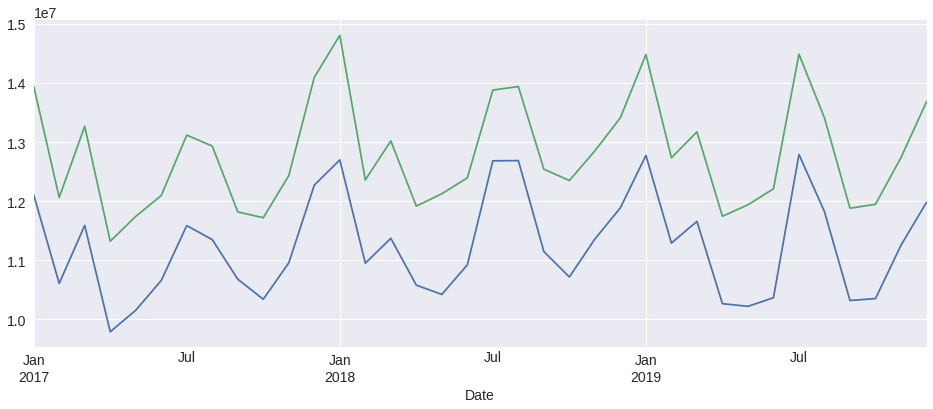

In [ ]:
MonthlyDemand = AllDemand.resample(rule='M').sum()
MonthlyDemand = MonthlyDemand.asfreq('M')
MonthlyDemand['Ontario Demand'].plot();
MonthlyDemand['Market Demand'].plot();

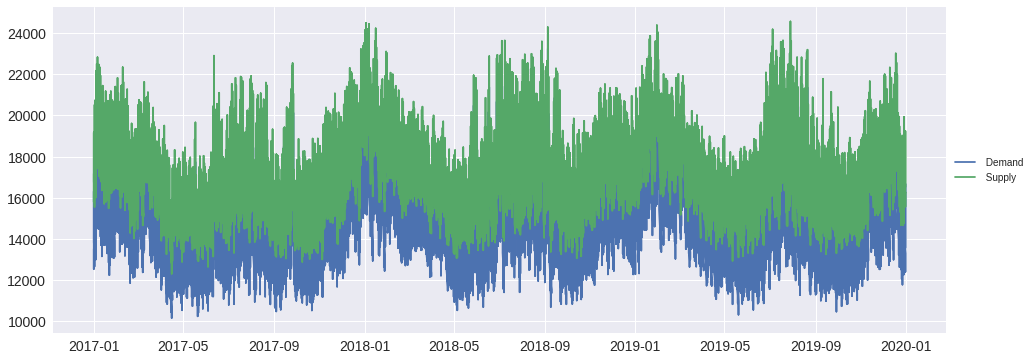

In [ ]:
y2=AllDemand['Ontario Demand']
y3= AllDemand['Market Demand']
x= MonthlyDemand
plt.plot(y2,label=' Demand')
plt.plot(y3,label=' Supply')

# use parameter bbox_to_anchor to reposition
# the legend box outside the plot area
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

As it is clear in the plot, the Electricity consumption has the highest usage in Jan/Dec.This might be due to several factors, the most obvious being new year and more electricity demand. Another major factor is the correlation between general weather condition and electricity usage. Extreme High and cold temperatures encourage more electricity usage as office buildings and homes require cooling and heating.


**Data Visualisation**
We can see the pattern in data- electricity usage seem to be very seasonal and repetitive. This makes sense, it migh be due to weather patterns,  holidays, weekends etc.
Furthermore, you can see the trend of the data seems to be trailing upwards in the last few years.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter

In [ ]:
weekly_data = Ontario_Demand.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()

## 6. Designing Models

###6.1. XGBoost



####Train & Test Split


In [ ]:
split_date = '31-Dec-2018'
Supply_train = Demand.loc[Demand.index <= split_date].copy() #changed from df_norm
Supply_test = Demand.loc[Demand.index > split_date].copy() #changed from df_norm

In [ ]:
print(Demand.shape)
print(Supply_train.shape)
print(Supply_test.shape)

(26280, 2)
(17520, 2)
(8760, 2)


Text(0.0, 1.0, 'Train - Test Split')

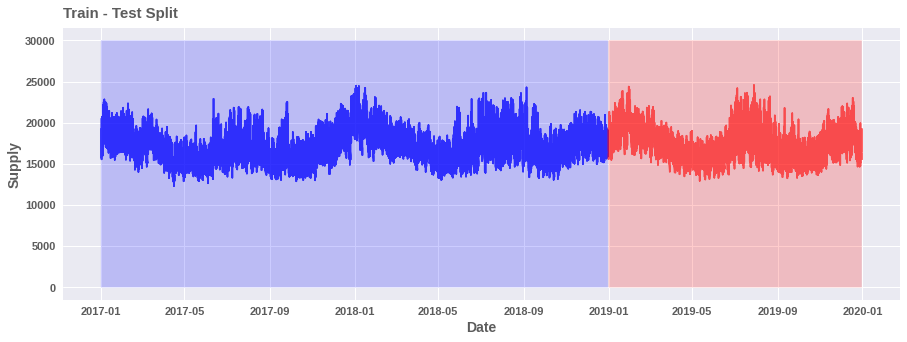

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 30000

plt.plot(Supply_train.index,Supply_train["Market Demand"],color="blue", alpha=0.75)
plt.fill_between(Supply_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(Supply_test.index,Supply_test["Market Demand"], color = "red", alpha=0.60)
plt.fill_between(Supply_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Supply", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [ ]:
#Train - Test
X_train = Supply_train.drop("Market Demand", axis=1) 
y_train = Supply_train["Market Demand"]
X_test = Supply_test.drop("Market Demand", axis=1)
y_test = Supply_test["Market Demand"]

####Creating XGBoost model

In [ ]:
import xgboost as xgb
xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)

[06:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

####Prediction

In [ ]:
Supply_test["Prediction"] = xgd_reg.predict(X_test)

In [ ]:
print(Supply_test["Prediction"])

Date
2019-01-01    15486.332031
2019-01-01    15119.996094
2019-01-01    14875.847656
2019-01-01    14719.686523
2019-01-01    14719.686523
                  ...     
2019-12-31    17876.496094
2019-12-31    17279.871094
2019-12-31    16768.105469
2019-12-31    16258.857422
2019-12-31    15865.635742
Name: Prediction, Length: 8760, dtype: float32


In [ ]:
data_compare1 = pd.DataFrame(Supply_test["Prediction"])
data_compare1.shape

(8760, 1)

In [ ]:
 data_compare2= pd.DataFrame(Demand_2019['Market Demand'])
 data_compare2.columns =['Actual']
 data_compare2['Date'] = Demand_2019['Date']
data_compare2

,Actual,Date
0,16231,2019-01-01
1,16051,2019-01-01
2,15805,2019-01-01
3,15580,2019-01-01
4,15609,2019-01-01
...,...,...
8755,18402,2019-12-31
8756,17574,2019-12-31
8757,16872,2019-12-31
8758,16562,2019-12-31


In [ ]:
data_compare3 = pd.merge_asof(data_compare1, data_compare2,
              on='Date')

data_compare3

,Date,Prediction,Actual
0,2019-01-01,15486.332031,16656
1,2019-01-01,15119.996094,16656
2,2019-01-01,14875.847656,16656
3,2019-01-01,14719.686523,16656
4,2019-01-01,14719.686523,16656
...,...,...,...
8755,2019-12-31,17876.496094,16527
8756,2019-12-31,17279.871094,16527
8757,2019-12-31,16768.105469,16527
8758,2019-12-31,16258.857422,16527


####EvaluationList item

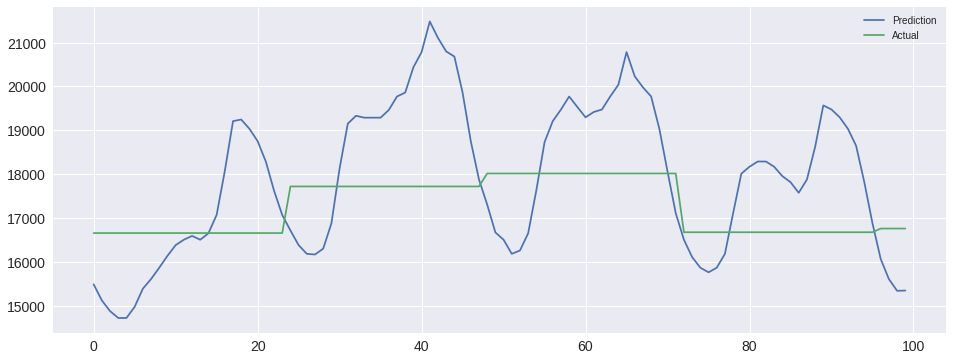

In [ ]:
data_compare3['Prediction'][:100].plot(legend=True)
data_compare3['Actual'][:100].plot(legend=True)

Text(0.0, 1.0, 'Predicted Supply')

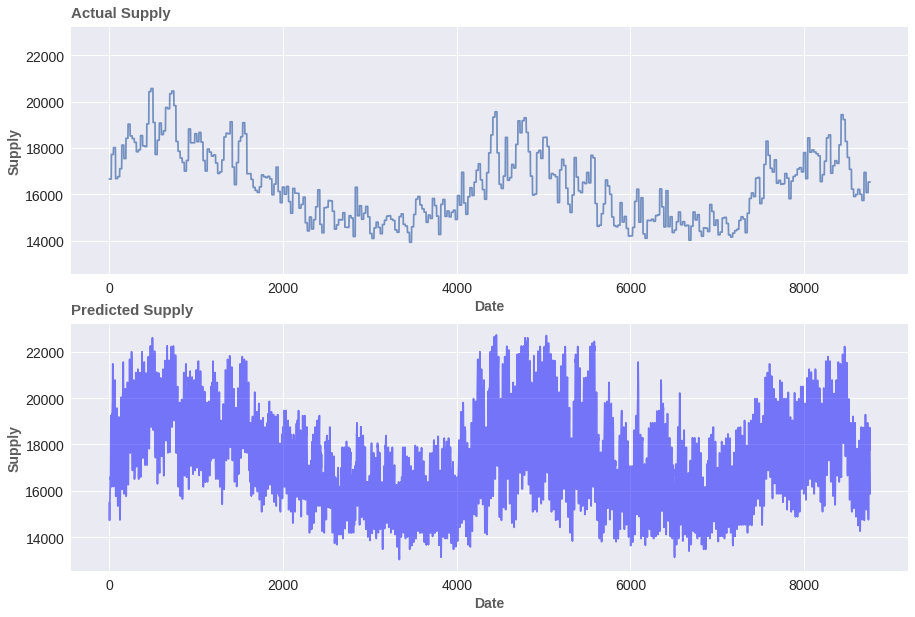

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(data_compare3.index,data_compare3["Actual"],alpha=0.75)
ax2.plot(data_compare3.index,data_compare3["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Supply", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Supply", alpha=0.75, weight="bold")

ax1.set_title("Actual Supply", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted Supply", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")                                                                                                                                                                              

###6.2. SARIMA

In [ ]:

Sarima_train = AllDemand[:'2017']
Sarima_validate = AllDemand['2018':'2018']
Sarima_test = AllDemand['2019':]

In [ ]:
Sarima_train.shape,validate.shape,test.shape

((8760, 5), (8760, 5), (8760, 5))

Text(0.0, 1.0, 'Train - Validate -Test Split')

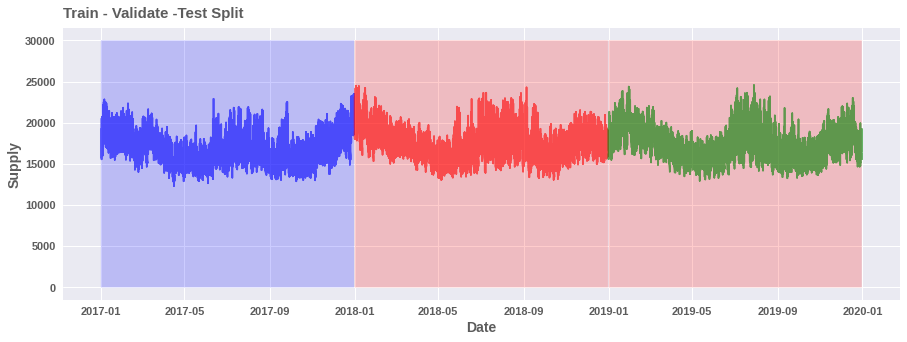

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 30000

plt.plot(Sarima_train.index,Sarima_train["Market Demand"],color="blue", alpha=0.60)
plt.fill_between(Sarima_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(Sarima_validate.index,Sarima_validate["Market Demand"], color = "red", alpha=0.60)
plt.fill_between(Sarima_validate.index,coloring, facecolor="red", alpha=0.2)

plt.plot(Sarima_test.index,Sarima_test["Market Demand"], color = "green", alpha=0.60)
plt.fill_between(Sarima_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Supply", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Validate -Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [ ]:
from pmdarima.arima import auto_arima


###6.2. RNN

####Train & Test Split

####Creating RNN model

####Prediction

####Evaluation

###6.3. LSTM

####Train & Test Split

####Creating LSTM model

####Prediction

####Evaluation

##7. Evaluating Final Models